# [[5,1,3]] Quantum Hamming Codes over (5,3) Hamming codes
A. Muh. Mufqi Zuhudi / moefqy@student.telkomuniversity.ac.id

---

## Import Libraries

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
import sympy as sp

In [2]:
# print full array of numpy (optional)
import sys, math, numpy
numpy.set_printoptions(threshold = sys.maxsize)

---

## Define Functions

In [3]:
# circuit generator
def circuit_gen(n,k):

    qr = QuantumRegister(n, 'q')
    cr = ClassicalRegister(n, 'c')

    sr = QuantumRegister(n-k, 'syndrome')
    crs = ClassicalRegister(n-k, 'cs')

    return QuantumCircuit(qr,cr,sr,crs)

In [4]:
# stabilizer generator
def stabilizer_gen(n,k,H,circuit):

    Hx = H[:, :H.shape[1] // 2]
    Hz = H[:, H.shape[1] // 2:]

    circuit.h(range(n,n+(n-k)))

    for i in range(n-k):
        for j in range(n):
            if Hx[i,j] == 1 and Hz[i,j] == 1:
                circuit.cy(n+i,j)
            elif Hx[i,j] == 1 and Hz[i,j] == 0:
                circuit.cx(n+i,j)
            elif Hx[i,j] == 0 and Hz[i,j] == 1:
                circuit.cz(n+i,j)

        # note: the barrier has meaning for the transpiler. if you are planning to execute that circuit, remember to remove the added barrier.
        circuit.barrier()
    
    circuit.h(range(n,n+(n-k)))

    return circuit

In [5]:
def encoder_gen(n,k,r,X_bar,H,circuit):
    
    Hx = H[:, :H.shape[1] // 2]
    Hz = H[:, H.shape[1] // 2:]

    for i in range(k):
        for j in range(r, n-k):
            if X_bar[i, j]:
                circuit.cx(n-k+i, j)
    
    # note: the barrier has meaning for the transpiler. if you are planning to execute that circuit, remember to remove the added barrier.
    circuit.barrier()
    
    for i in range(r):
        circuit.h(i)
        
        for j in range(n):
            if i == j:
                continue
            elif Hx[i, j] and Hz[i, j]:
                circuit.cx(i, j)
                circuit.cz(i, j)
                # circuit.cy(i, j)
            elif Hx[i, j]:
                circuit.cx(i, j)
            elif Hz[i, j]:
                circuit.cz(i, j)
    
        # note: the barrier has meaning for the transpiler. if you are planning to execute that circuit, remember to remove the added barrier.
        circuit.barrier()
    
    return circuit

In [6]:
def gauss_jordan(H):
    
    # compute the rref
    H_gauss_jordan = H.rref()[0]

    # perform modular arithmetic element-wise with modulo 2
    H_gauss_jordan = H_gauss_jordan.applyfunc(lambda x: sp.Mod(x, 2))

    return H_gauss_jordan

---

## Define Parameters

In [7]:
# define parameter
k = 1
n = 5
r = 4

In [8]:
# define PCM for the [[5,1,3]] Hamming codes
# define Hx
Hx = sp.Matrix([
    [1,1,1,1,0],
    [1,1,1,0,1],
    [0,1,1,0,0],
    [1,1,0,0,0]
], dtype=int)

# define Hz
Hz = sp.Matrix([
    [0,1,1,0,0],
    [1,1,0,0,0],
    [1,0,0,1,0],
    [0,0,1,0,1]
], dtype=int)

# define H
H = Hx.row_join(Hz)

# print H
H

Matrix([
[1, 1, 1, 1, 0, 0, 1, 1, 0, 0],
[1, 1, 1, 0, 1, 1, 1, 0, 0, 0],
[0, 1, 1, 0, 0, 1, 0, 0, 1, 0],
[1, 1, 0, 0, 0, 0, 0, 1, 0, 1]])

In [9]:
# calculate SIP
SIP = (Hx * Hz.transpose() + Hz * Hx.transpose()) % 2

# print SIP
SIP

Matrix([
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0]])

In [10]:
# perform gauss jordan elimination on H
H_gauss_jordan = gauss_jordan(H)

# print H_gauss_jordan
H_gauss_jordan

Matrix([
[1, 0, 0, 0, 1, 0, 1, 0, 1, 0],
[0, 1, 0, 0, 1, 0, 1, 1, 1, 1],
[0, 0, 1, 0, 1, 1, 1, 1, 0, 1],
[0, 0, 0, 1, 1, 1, 0, 1, 0, 0]])

In [11]:
# define logical operator X (manually)
X_bar = sp.Matrix([
    [0, 0, 0, 0, 1, 0, 1, 1, 0, 0]
], dtype=int)

# print X_bar
X_bar

Matrix([[0, 0, 0, 0, 1, 0, 1, 1, 0, 0]])

In [12]:
# define logical operator Z (manually)
Z_bar = sp.Matrix([
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
], dtype=int)

# print Z_bar
Z_bar

Matrix([[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]])

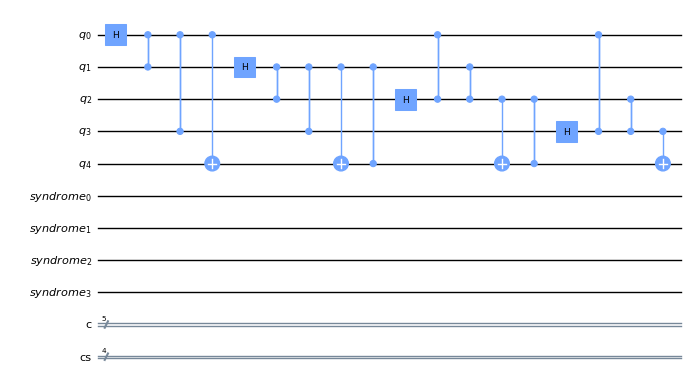

In [13]:
# define initial circuit
encoder_circ = circuit_gen(n,k)

# define encoder circuit
encoder_circ = encoder_gen(n,k,r,X_bar,H_gauss_jordan,encoder_circ)

# draw circuit
encoder_circ.draw(output='mpl', plot_barriers=False, scale=0.5)

In [14]:
# Execute the circuit on a simulator backend
backend = Aer.get_backend('unitary_simulator')
job = execute(encoder_circ, backend, shots=1000)
result = job.result()

# get unitary matrix (optional)
unitary = result.get_unitary(encoder_circ,3)
print(unitary)

Operator([[ 0.25+0.j,  0.25-0.j,  0.25-0.j,  0.25-0.j,  0.25-0.j,
            0.25-0.j,  0.25-0.j,  0.25-0.j,  0.25-0.j,  0.25-0.j,
            0.25-0.j,  0.25-0.j,  0.25-0.j,  0.25-0.j,  0.25-0.j,
            0.25-0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,
            0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,
            0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,
            0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,
            0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,
            0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,
            0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,
            0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,
            0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,
            0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,
            0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,
            0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,
          

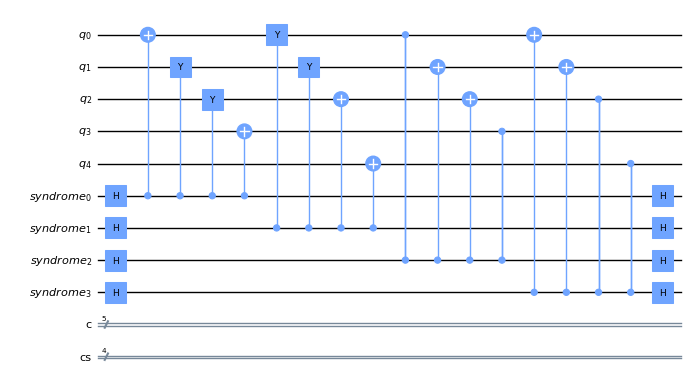

In [15]:
# define initial circuit
stabilizer_circ = circuit_gen(n,k)

# define stabilizer circuit
stabilizer_circ = stabilizer_gen(n,k,H,stabilizer_circ)

# draw circuit
stabilizer_circ.draw(output='mpl', plot_barriers=False, scale=0.5)

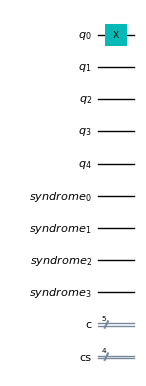

In [16]:
# define initial circuit
error_circ = circuit_gen(n,k)

# define error
error_circ.barrier()
error_circ.x(0) # add the error here
error_circ.barrier()

# draw circuit
error_circ.draw(output='mpl', plot_barriers=False, scale=0.5)

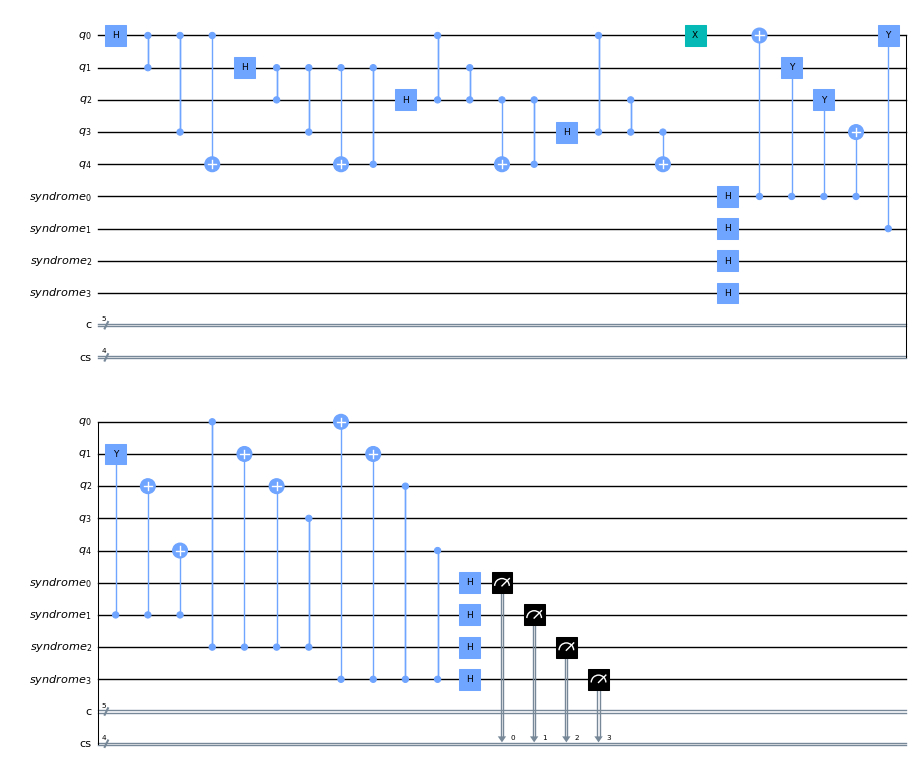

In [17]:
# define full circuit
circ = encoder_circ.compose(error_circ).compose(stabilizer_circ)

# measure the syndrome
circ.measure(range(n,n+(n-k)),range(n,n+(n-k)))

# draw circuit
circ.draw(output='mpl', plot_barriers=False, scale=0.5)

In [18]:
# Execute the circuit on a simulator backend
backend = Aer.get_backend('qasm_simulator')
job = execute(circ, backend, shots=1)
result = job.result()

# measure the syndromes
counts = result.get_counts(circ)
print(counts)

{'0110 00000': 1}


---

## Calculate All Error Syndrome

In [19]:
# define the Pauli list
pauli_list = [
    'IIIII',
    'XIIII',
    'IXIII',
    'IIXII',
    'IIIXI',
    'IIIIX',
    'YIIII',
    'IYIII',
    'IIYII',
    'IIIYI',
    'IIIIY',
    'ZIIII',
    'IZIII',
    'IIZII',
    'IIIZI',
    'IIIIZ'
]

# define dummy list
syndrome_result = []

# iterate over the Pauli list and apply the corresponding gates
for pauli in pauli_list:

    # define initial circuit
    error_circ = circuit_gen(n,k)

    for i, gate in enumerate(pauli):
        error_circ.barrier()
        if gate == 'X':
            error_circ.x([i])
        elif gate == 'Y':
            error_circ.y([i])
        elif gate == 'Z':
            error_circ.z([i])
        error_circ.barrier()

    # define full circuit
    circ = encoder_circ.compose(error_circ).compose(stabilizer_circ)

    # measure the syndrome
    circ.measure(range(n,n+(n-k)),range(n,n+(n-k)))

    # Execute the circuit on a simulator backend
    backend = Aer.get_backend('qasm_simulator')
    job = execute(circ, backend, shots=1)
    result = job.result()

    # measure the syndromes
    counts = result.get_counts(circ)
    syndrome_result.append(str(counts))
    print('Measured syndrome of ', pauli, ' are: ', str(counts))


total_count = len(syndrome_result)

unique_syndrome = set(syndrome_result)
unique_count = len(unique_syndrome)

print('----------------------------------------------------------')
print('Unique syndrome is ', unique_count, ' out of ', total_count)

Measured syndrome of  IIIII  are:  {'0000 00000': 1}
Measured syndrome of  XIIII  are:  {'0110 00000': 1}
Measured syndrome of  IXIII  are:  {'0011 00000': 1}
Measured syndrome of  IIXII  are:  {'1001 00000': 1}
Measured syndrome of  IIIXI  are:  {'0100 00000': 1}
Measured syndrome of  IIIIX  are:  {'1000 00000': 1}
Measured syndrome of  YIIII  are:  {'1101 00000': 1}
Measured syndrome of  IYIII  are:  {'1100 00000': 1}
Measured syndrome of  IIYII  are:  {'1110 00000': 1}
Measured syndrome of  IIIYI  are:  {'0101 00000': 1}
Measured syndrome of  IIIIY  are:  {'1010 00000': 1}
Measured syndrome of  ZIIII  are:  {'1011 00000': 1}
Measured syndrome of  IZIII  are:  {'1111 00000': 1}
Measured syndrome of  IIZII  are:  {'0111 00000': 1}
Measured syndrome of  IIIZI  are:  {'0001 00000': 1}
Measured syndrome of  IIIIZ  are:  {'0010 00000': 1}
----------------------------------------------------------
Unique syndrome is  16  out of  16
